# Trabajo Práctico: Extracción de Petróleo 🛢️

Este notebook implementa la resolución de una ecuación diferencial ordinaria (EDO) que modela el perfil de temperatura radial en una tubería de extracción de petróleo de alta presión y temperatura.

Se resuelve el siguiente problema de valor en la frontera:


$$
r \cdot \frac{d^2T}{dr^2} + \frac{dT}{dr} = 0
$$



Con condiciones de borde (padrón 110616):

- $$ T(r_1) = T_1 = 406^\circ C $$
- $$ T(r_2) = T_2 = 16^\circ C $$

Usaremos el **método del tiro** junto con **Euler** para resolverlo numéricamente.


## ctes:

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema

R1 = 101.6  # mm
R2 = 113.6  # mm

T1 = 406    # °C
T2 = 16    # °C

S1 = -100 # valor inicial del primer tiro
S2 = -1 # valor inicial del segundo tiro

h = 1.0 #paso de 1 mm

resultados = {}

## Método del Tiro 🎯




In [51]:
def u_real(r):
    A = (T1 - T2) / (np.log(R1) - np.log(R2))
    B = T1 - A * np.log(R1)
    return A * np.log(r) + B

In [52]:
# Solución exacta para comparar
def T_exacta(r):
    return (T1 - T2) * np.log(R2 / r) / np.log(R2 / R1) + T2

def metodo_del_tiro(h, func):
    s1, s2 = S1, S2  # valores iniciales tentativos

    r, u1 = func(s1, h)
    resultados["euler_explicito_tiro_1"] = (r, u1)
    r, u2 = func(s2, h)
    resultados["euler_explicito_tiro_2"] = (r, u2)

    # Interpolación lineal (una sola vez)
    s_new = s2 + ((s1-s2)/(u1[-1] - u2[-1])) * (T2-u2[-1])

    #print(f"\n Derivada inicial interpolada: {s_new:.6f}")

    # Ejecutar Euler una sola vez con la derivada corregida
    r, u3 = func(s_new, h)

    resultados["euler_explicito_tiro_3"] = (r, u3)



    return r, u3, s_new


def imprimir_resultados_metodo_del_tiro(r, u3, s_new):

    print(f"{2:9d} | {s_new:8.4f} | {u3[-1]:11.6f} | {abs(u3[-1] - T2):.6f}")

    print(f"\nError final real: {abs(u3[-1] - T2):.12f}")

    # Mostrar error en cada paso comparado con solución exacta
    print("\n📈 Errores punto a punto respecto a la solución exacta:")
    print("Paso | r        | u_num      | u_exact    | Error")
    print("------------------------------------------------------")
    for i in range(len(r)):
        r_i = r[i]
        u_i = u3[i]
        u_ex = u_real(r_i)
        error = abs(u_i - u_ex)
        print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_ex:10.4f} | {error:8.4f}")



In [53]:
def tolerance_reduction(h_max, func, tolerance, max_iterations=20):
    """
    Encuentra el valor más grande de h en [h_min, h_max] tal que el error máximo sea <= tolerance.
    Usa búsqueda binaria.
    """
    iter_count = 0
    h_opt = h_max  # Lo inicializamos en el máximo
    h_min = 0

    while (h_max - h_min) > 1e-6 and iter_count < max_iterations:
        h_mid = (h_min + h_max) / 2.0
        print(f"\n=== Ejecutando con h = {h_mid:.5f} mm ===")
        r, u, s_final = metodo_del_tiro(h_mid, func)

        errores = [abs(u[i] - u_real(r[i])) for i in range(len(r))]
        error_max = max(errores)

        print(f"Máximo error punto a punto: {error_max:.6f} °C")

        if error_max < tolerance:
            # Puede que haya uno más grande que también cumpla la condición
            h_min = h_mid
            h_opt = h_mid
        else:
            # Demasiado grande, reducir
            h_max = h_mid

        iter_count += 1

    print(f"\nPaso final elegido: {h_opt:.5f} mm con error máximo de {error_max:.6f} °C")
    r, u, s_final = metodo_del_tiro(h_opt, func)
    imprimir_resultados_metodo_del_tiro(r, u, s_final)


## Euler Explicito

### codigo


In [54]:
def euler_system(s, h):
    r = R1
    u = T1
    v = s

    r_values = [r]
    u_values = [u]
    v_values = [v]

    n = 0
    while r < R2:
        u = u + h * v
        #print(u, v)
        v = v + h * (-v / r)
        r = R1 + h * (n + 1)
        n += 1

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)

    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")

    return np.array(r_values), np.array(u_values)
#euler_system(-1,1)


### Resultados y comparación con solución exacta

Graficamos la solución obtenida por Euler y la solución exacta:


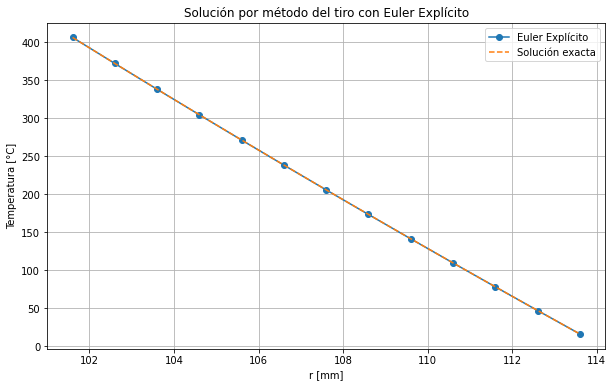

Derivada inicial encontrada (s): -34.2405240298
Error final: 0.0000000000 °C
        2 | -34.2405 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 |   406.0000 |   406.0000 |   0.0000
   1 |   102.60 |   371.7595 |   371.7845 |   0.0250
   2 |   103.60 |   337.8560 |   337.9009 |   0.0449
   3 |   104.60 |   304.2829 |   304.3428 |   0.0599
   4 |   105.60 |   271.0339 |   271.1040 |   0.0701
   5 |   106.60 |   238.1028 |   238.1785 |   0.0757
   6 |   107.60 |   205.4835 |   205.5604 |   0.0769
   7 |   108.60 |   173.1702 |   173.2440 |   0.0738
   8 |   109.60 |   141.1572 |   141.2239 |   0.0667
   9 |   110.60 |   109.4390 |   109.4946 |   0.0556
  10 |   111.60 |    78.0102 |    78.0509 |   0.0407
  11 |   112.60 |    46.8656 |    46.8877 |   0.0221
  12 |   113.60 |    16.0000 |    16.0000 |   

In [55]:
r_vals, u_vals, s_final = metodo_del_tiro(h, euler_system)
r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)
resultados["euler_solucion_exacta"] = (r_exacto, T_exacta)



# Graficamos
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura (ancho x alto en pulgadas)
plt.plot(r_vals, u_vals, 'o-', label='Euler Explícito')
plt.plot(r_exacto, T_exacto, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con Euler Explícito')
plt.legend()
plt.grid()
plt.show()

print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)




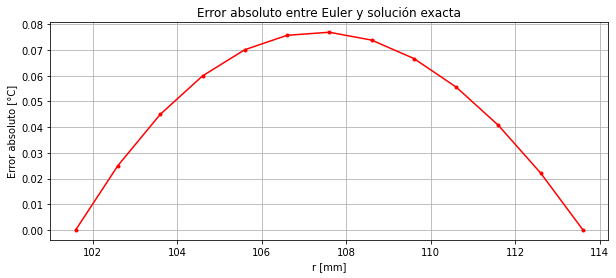

In [56]:

# Interpolamos la solución exacta en los mismos puntos que u_vals
T_interp = T_exacta(r_vals)
error = np.abs(u_vals - T_interp)

plt.figure(figsize=(10, 4))
plt.plot(r_vals, error, 'r.-')
plt.xlabel('r [mm]')
plt.ylabel('Error absoluto [°C]')
plt.title('Error absoluto entre Euler y solución exacta')
plt.grid()
plt.show()


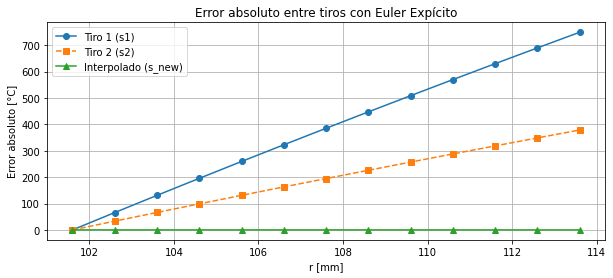

In [57]:
# Obtener los resultados de cada tiro
r1, u1 = resultados["euler_explicito_tiro_1"]
r2, u2 = resultados["euler_explicito_tiro_2"]
r3, u3 = resultados["euler_explicito_tiro_3"]
r_exacto, T_exacta = resultados["euler_solucion_exacta"]

# Interpolamos la solución exacta en los mismos puntos que u_vals
T_interp = T_exacta(r_vals)
error1 = np.abs(u1 - T_interp)
error2 = np.abs(u2 - T_interp)
error3 = np.abs(u3 - T_interp)



plt.figure(figsize=(10, 4))
plt.plot(r1, error1, 'o-', label='Tiro 1 (s1)')
plt.plot(r2, error2, 's--', label='Tiro 2 (s2)')
plt.plot(r3, error3,'^-', label='Interpolado (s_new)')

plt.xlabel('r [mm]')
plt.ylabel('Error absoluto [°C]')
plt.title('Error absoluto entre tiros con Euler Expícito')
plt.legend()
plt.grid()
plt.show()


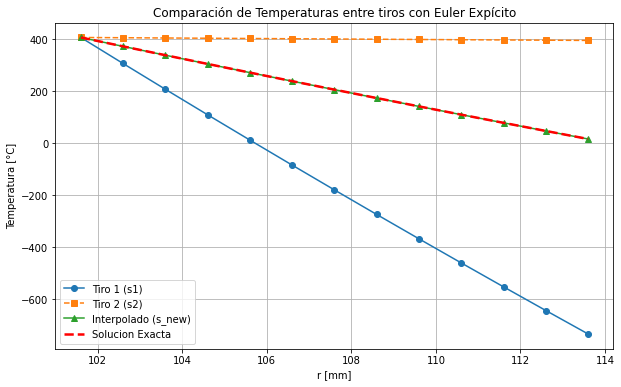

In [58]:
# Obtener los resultados de cada tiro
r1, u1 = resultados["euler_explicito_tiro_1"]
r2, u2 = resultados["euler_explicito_tiro_2"]
r3, u3 = resultados["euler_explicito_tiro_3"]

u_exacta = []
for r in r1:
    u_exacta.append(T_exacta(r))

#r_exacto, T_exacta = resultados["euler_solucion_exacta"]



plt.figure(figsize=(10, 6))
plt.plot(r1, u1, 'o-', label='Tiro 1 (s1)')
plt.plot(r2, u2, 's--', label='Tiro 2 (s2)')
plt.plot(r3, u3, '^-', label='Interpolado (s_new)')
plt.plot(r1, u_exacta, '--', label='Solucion Exacta', color='red',  linewidth=2.5)

plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Comparación de Temperaturas entre tiros con Euler Expícito')
plt.legend()
plt.grid()
plt.show()




### Tolerancia Euler Explicito < 0.02

In [59]:
tolerance_reduction(1, euler_system, 0.02)


=== Ejecutando con h = 0.50000 mm ===
Máximo error punto a punto: 0.038202 °C

=== Ejecutando con h = 0.25000 mm ===
Máximo error punto a punto: 0.019065 °C

=== Ejecutando con h = 0.37500 mm ===
Máximo error punto a punto: 0.028626 °C

=== Ejecutando con h = 0.31250 mm ===
Máximo error punto a punto: 5.761156 °C

=== Ejecutando con h = 0.28125 mm ===
Máximo error punto a punto: 2.881766 °C

=== Ejecutando con h = 0.26562 mm ===
Máximo error punto a punto: 6.720426 °C

=== Ejecutando con h = 0.25781 mm ===
Máximo error punto a punto: 3.601836 °C

=== Ejecutando con h = 0.25391 mm ===
Máximo error punto a punto: 5.761156 °C

=== Ejecutando con h = 0.25195 mm ===
Máximo error punto a punto: 2.881766 °C

=== Ejecutando con h = 0.25098 mm ===
Máximo error punto a punto: 1.441180 °C

=== Ejecutando con h = 0.25049 mm ===
Máximo error punto a punto: 0.720664 °C

=== Ejecutando con h = 0.25024 mm ===
Máximo error punto a punto: 0.360351 °C

=== Ejecutando con h = 0.25012 mm ===
Máximo error 

## Método de Euler Implícito

### Sistema de ecuaciones

Redefinimos la segunda orden como un sistema de primer orden usando:

- $$ u = T $$
- $$ v = \frac{du}{dr} = T' $$

Entonces:

$$
\begin{cases}
\frac{du}{dr} = v \\
\frac{dv}{dr} = -\frac{v}{r}
\end{cases}
$$


$$       
u_{n+1} = u_{n} + h \cdot v_{n+1}
$$
$$
v_{n+1} = v_{n} + h \cdot \left(-\frac{v_{n+1}}{r_{n+1}}\right)
$$

In [60]:
def euler_implicit(s, h):
    r = R1
    u = T1
    v = s

    r_values = [r]
    u_values = [u]
    v_values = [v]

    n = 0
    while r < R2:
        #print(u, v)
        v = v / (1 + h / r)
        u = u + h * v 
        r = R1 + h * (n + 1)
        n += 1

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)

    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")

    return np.array(r_values), np.array(u_values)
#euler_implicit(-1,1)


### Resultados y comparación con solución exacta

Graficamos la solución obtenida por Euler y la solución exacta:


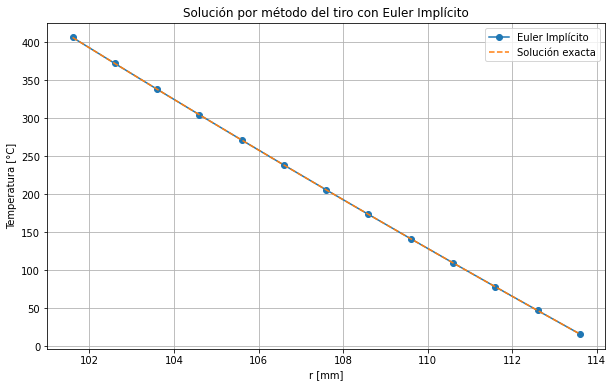

Derivada inicial encontrada (s): -34.5439411165
Error final: 0.0000000000 °C
        2 | -34.5439 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 |   406.0000 |   406.0000 |   0.0000
   1 |   102.60 |   371.7927 |   371.7845 |   0.0082
   2 |   103.60 |   337.9157 |   337.9009 |   0.0148
   3 |   104.60 |   304.3625 |   304.3428 |   0.0197
   4 |   105.60 |   271.1270 |   271.1040 |   0.0230
   5 |   106.60 |   238.2033 |   238.1785 |   0.0249
   6 |   107.60 |   205.5856 |   205.5604 |   0.0253
   7 |   108.60 |   173.2683 |   173.2440 |   0.0243
   8 |   109.60 |   141.2458 |   141.2239 |   0.0219
   9 |   110.60 |   109.5129 |   109.4946 |   0.0183
  10 |   111.60 |    78.0642 |    78.0509 |   0.0134
  11 |   112.60 |    46.8949 |    46.8877 |   0.0073
  12 |   113.60 |    16.0000 |    16.0000 |   

In [61]:
h = 1

r_vals, u_vals, s_final = metodo_del_tiro(h, euler_implicit)

# Solución exacta para comparar
def T_exacta(r):
    return (T1 - T2) * np.log(R2 / r) / np.log(R2 / R1) + T2

r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)

# Graficamos
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura (ancho x alto en pulgadas)
plt.plot(r_vals, u_vals, 'o-', label='Euler Implícito')
plt.plot(r_exacto, T_exacto, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con Euler Implícito')
plt.legend()
plt.grid()
plt.show()

print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)




### Tolerancia

In [69]:
tolerance_reduction(1,euler_implicit, 0.02, 2)


=== Ejecutando con h = 0.50000 mm ===
Máximo error punto a punto: 0.012642 °C

=== Ejecutando con h = 0.75000 mm ===
Máximo error punto a punto: 0.018955 °C

Paso final elegido: 0.75000 mm con error máximo de 0.018955 °C
        2 | -34.5038 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 |   406.0000 |   406.0000 |   0.0000
   1 |   102.35 |   380.3118 |   380.3070 |   0.0047
   2 |   103.10 |   354.8104 |   354.8016 |   0.0088
   3 |   103.85 |   329.4932 |   329.4811 |   0.0121
   4 |   104.60 |   304.3576 |   304.3428 |   0.0148
   5 |   105.35 |   279.4008 |   279.3841 |   0.0168
   6 |   106.10 |   254.6205 |   254.6024 |   0.0181
   7 |   106.85 |   230.0142 |   229.9953 |   0.0188
   8 |   107.60 |   205.5793 |   205.5604 |   0.0190
   9 |   108.35 |   181.3136 |   181.2951 |   0.0185
  10 | 

## RK2


### codigo

In [65]:
# Implementación de RK2 para el sistema
def rk2_system(s, h):
    r_values = [R1]
    u_values = [T1]
    v_values = [s]

    r = R1
    u = T1
    v = s

    while r < R2:
        q1u = h * v
        q1v = h* (-v / r)
        
        q2u = h* (v + q1v)
        q2v = h* (-(v + q1v) / (r))
        
        u = u + ((q1u + q2u) / 2)
        v = v + ((q1v + q2v) / 2)
        r = r + h

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)




    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")

    return np.array(r_values), np.array(u_values)


#rk2_system(-1,1)


### Resultados

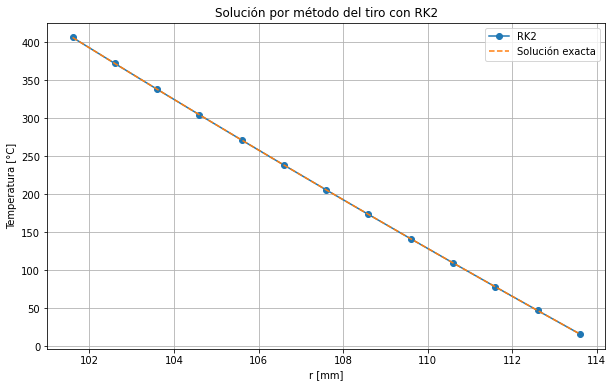

Derivada inicial encontrada (s): -34.3929455106
Error final: 0.0000000000 °C
        2 | -34.3929 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 |   406.0000 |   406.0000 |   0.0000
   1 |   102.60 |   371.7763 |   371.7845 |   0.0082
   2 |   103.60 |   337.8862 |   337.9009 |   0.0147
   3 |   104.60 |   304.3232 |   304.3428 |   0.0196
   4 |   105.60 |   271.0810 |   271.1040 |   0.0230
   5 |   106.60 |   238.1536 |   238.1785 |   0.0248
   6 |   107.60 |   205.5352 |   205.5604 |   0.0252
   7 |   108.60 |   173.2198 |   173.2440 |   0.0242
   8 |   109.60 |   141.2020 |   141.2239 |   0.0219
   9 |   110.60 |   109.4764 |   109.4946 |   0.0182
  10 |   111.60 |    78.0375 |    78.0509 |   0.0133
  11 |   112.60 |    46.8804 |    46.8877 |   0.0073
  12 |   113.60 |    16.0000 |    16.0000 |   

In [66]:
r_vals, u_vals, s_final = metodo_del_tiro(h, rk2_system)




u_exacta = []
for r in r_vals:
    u_exacta.append(T_exacta(r))


r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)

plt.figure(figsize=(10, 6))
plt.plot(r_vals, u_vals, 'o-', label='RK2')
plt.plot(r_vals, u_exacta, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con RK2')
plt.legend()
plt.grid()


plt.show()


print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)


### Cambio de paso h en RK2


In [67]:
tolerance_reduction(1, rk2_system, 0.02, 2)


=== Ejecutando con h = 0.50000 mm ===
Máximo error punto a punto: 0.012631 °C

=== Ejecutando con h = 0.75000 mm ===
Máximo error punto a punto: 0.018931 °C

Paso final elegido: 0.75000 mm con error máximo de 0.018931 °C
        2 | -34.3906 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 |   406.0000 |   406.0000 |   0.0000
   1 |   102.35 |   380.3023 |   380.3070 |   0.0047
   2 |   103.10 |   354.7929 |   354.8016 |   0.0088
   3 |   103.85 |   329.4690 |   329.4811 |   0.0121
   4 |   104.60 |   304.3281 |   304.3428 |   0.0147
   5 |   105.35 |   279.3674 |   279.3841 |   0.0167
   6 |   106.10 |   254.5844 |   254.6024 |   0.0181
   7 |   106.85 |   229.9765 |   229.9953 |   0.0188
   8 |   107.60 |   205.5414 |   205.5604 |   0.0189
   9 |   108.35 |   181.2767 |   181.2951 |   0.0185
  10 | 